In [2]:
!python --version

Python 3.12.7


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional,Flatten, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [2]:
def getUnreadableCount(df):
    return (df['IDENTITY'] == 'UNREADABLE').sum();

def getLowercaseCount(df):
    return (df['IDENTITY'].str.islower()).sum();

def getDigitCount(df):
    return (df['IDENTITY'].str.isdigit()).sum();

def removeUnreadableEntries(df):
    is_unreadable = df['IDENTITY'] != 'UNREADABLE';
    df = df[is_unreadable];
    return df;

def removeDigitEntries(df):
    is_digit = df['IDENTITY'].str.isdigit();
    df = df[is_digit];
    return df;

def cleanDataSet(df):
    # Drop rows with any NaN values
    empty_count = df.isnull().sum().sum()
    if empty_count > 0:
        df.dropna(inplace=True)

    # Remove unreadable entries if any
    unreadable_count = getUnreadableCount(df)
    if unreadable_count > 0:
        df = removeUnreadableEntries(df)

    # Remove entries with digits if any
    digit_count = getDigitCount(df)
    if digit_count > 0:
        df = removeDigitEntries(df)

    # Convert 'IDENTITY' column to uppercase if there are any lowercase values
    lowercase_count = getLowercaseCount(df)
    if lowercase_count > 0:
        df.loc[:, 'IDENTITY'] = df['IDENTITY'].str.upper()

    # Keep only rows with 'FILENAME' ending in '.jpg'
    # Instead of summing over booleans, we directly filter for .jpg files
    df = df[df['FILENAME'].str.endswith('.jpg')]

    return df

def num_to_char(num):
    label = ""
    for ch in num:
        if ch == -1:
            break
        label+=alphabet_characters[ch]
    return label

def ctc_loss_function(args):
    y_pred, y_true, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [3]:
train_size = 50000
valid_size= 10000
alphabet_characters = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
num_of_characters = len(alphabet_characters) + 1
num_of_timestamps = 64

In [4]:
training_written_df = pd.read_csv("C:/Users/brysa/Downloads/ml_project/ai images/written_name_train_v2.csv")
validation_written_df = pd.read_csv('C:/Users/brysa/Downloads/ml_project/ai images/written_name_validation_v2.csv')

In [5]:
training_written_df = cleanDataSet(training_written_df);
validation_written_df = cleanDataSet(validation_written_df);

# To make sure our indices are one behind the other
training_written_df.reset_index(inplace = True, drop=True)
validation_written_df.reset_index(inplace = True, drop=True)

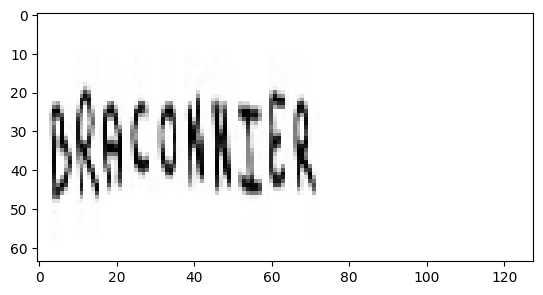

In [6]:
i = 128;
img_dir = 'C:/Users/brysa/Downloads/ml_project/ai images/train_v2/train/'+training_written_df.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(image, (128, 64))
plt.imshow(new_img, cmap = 'gray')
plt.show()

In [7]:
valid_x = []
for i in range(valid_size):
    img_dir = 'C:/Users/brysa/Downloads/ml_project/ai images/validation_v2/validation/'+validation_written_df.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    valid_x.append(image)

train_x = []
for j in range(train_size):
    img_dir = 'C:/Users/brysa/Downloads/ml_project/ai images/train_v2/train/'+training_written_df.loc[j, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    train_x.append(image)


In [8]:
valid_x = np.array(valid_x).reshape(-1, 256, 32, 1)
train_x = np.array(train_x).reshape(-1, 256, 32, 1)

str_len = training_written_df["IDENTITY"].str.len().max()


In [9]:
train_y = np.ones([train_size, str_len]) * -1

train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

valid_y = np.ones([valid_size, str_len]) * -1

valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

In [10]:
for i in range(train_size):
    label = []
    for ch in training_written_df['IDENTITY'][i]:
        label.append(alphabet_characters.index(ch))
    arr = np.array(label)
    train_y[i, 0:len(training_written_df.loc[i, 'IDENTITY'])] = arr;
    train_label_len[i] = len(training_written_df.loc[i, 'IDENTITY'])


for i in range(valid_size):
    label = []
    for ch in validation_written_df['IDENTITY'][i]:
        label.append(alphabet_characters.index(ch))
    arr = np.array(label)
    valid_y[i, 0:len(validation_written_df.loc[i, 'IDENTITY'])] = arr;
    valid_label_len[i] = len(validation_written_df.loc[i, 'IDENTITY'])


In [11]:
model_seq = Sequential()

model_seq.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 32, 1)))
model_seq.add(Activation('relu'))
model_seq.add(MaxPooling2D(pool_size=(2, 2)))
model_seq.add(BatchNormalization())

model_seq.add(Conv2D(64, (3, 3), padding='same'))
model_seq.add(Activation('relu'))
model_seq.add(MaxPooling2D(pool_size=(1, 2)))
model_seq.add(Dropout(0.3))
model_seq.add(BatchNormalization())

model_seq.add(Flatten())
model_seq.add(Dropout(0.3))

model_seq.add(Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1'))
model_seq.add(Activation('relu'))
model_seq.add(Dropout(0.2))

model_seq.add(Dense(34))
model_seq.add(Activation('relu'))
model_seq.add(Dropout(0.2))
model_seq.add(Activation('softmax'))

input_data = Input(shape=(256, 32, 1), name='input')
y_pred_seq = model_seq(input_data)

c:\Users\brysa\Downloads\ml_project\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
optimizer = 'adam'
model_seq.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=optimizer, metrics=['accuracy'])

model_seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 32, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 16, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 16, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 16, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 8, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         2,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 34)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,778 (16.08 MB)

 Trainable params: 4,215,586 (16.08 MB)

 Non-trainable params: 192 (768.00 B)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)
]

In [14]:
seq_history = model_seq.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=30, batch_size=64, callbacks=my_callbacks)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 130s 164ms/step - accuracy: 0.1975 - loss: 2.7188 - val_accuracy: 0.2436 - val_loss: 2.7181
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 130s 166ms/step - accuracy: 0.2133 - loss: 2.7203 - val_accuracy: 0.2436 - val_loss: 2.7181
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 137s 175ms/step - accuracy: 0.1782 - loss: 2.7178 - val_accuracy: 0.1463 - val_loss: 2.7180
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - accuracy: 0.1841 - loss: 2.7212 - val_accuracy: 0.2436 - val_loss: 2.7181
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 187ms/step - accuracy: 0.2239 - loss: 2.7170 - val_accuracy: 0.1463 - val_loss: 2.7180
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 153s 195ms/step - accuracy: 0.1609 - loss: 2.7257 - val_accuracy: 0.1463 - val_loss: 2.7180
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 205ms/step - accuracy: 0.1634 - loss: 2.7154 - val_accuracy: 0.2431 - val_loss: 2.7181
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 167s 213ms/step - accuracy: 0.2099 -

In [15]:
input_data = Input(shape=(256, 32, 1))

cnn_layer = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)

cnn_layer = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(1, 2))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)

cnn_layer = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(1, 1))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)

cnn_layer = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)

# CNN to RNN
reshaped_layer = Reshape(target_shape=((64, 1024)))(cnn_layer)
dense_layer = Dense(64, activation='relu', kernel_initializer='he_normal')(reshaped_layer)

## RNN
rnn_layer = Bidirectional(LSTM(256, return_sequences=True))(dense_layer)
rnn_layer = Bidirectional(LSTM(256, return_sequences=True))(rnn_layer)

## OUTPUT
final_dense_layer = Dense(num_of_characters, kernel_initializer='he_normal')(rnn_layer)
y_pred = Activation('softmax')(final_dense_layer)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 32, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 32, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 32, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 16, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 16, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 16, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 8, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 8, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 8, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 8, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128, 8, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64, 512)        │       657,40

 Total params: 2,703,070 (10.31 MB)

 Trainable params: 2,702,110 (10.31 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)
]

In [17]:
true_labels = Input(shape=[str_len], dtype='float32')
input_length = Input(shape=[1], dtype='int64')
label_length = Input(shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_loss_function, output_shape=(1,), name='ctc_loss')([y_pred, true_labels, input_length, label_length])
model_final = Model(inputs=[input_data, true_labels, input_length, label_length], outputs=ctc_loss)

In [18]:
model_final.compile(loss={'ctc_loss' : lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

In [19]:
model_final.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 32,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 32,   │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32,   │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256, 32,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 16,   │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 16,   │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 16,   │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 128, 16,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 8,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128, 8,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 8,    │     73,856 │ dropout_4[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 8,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 128, 8,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 8,    │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 8,    │          0 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 8,    │    295,168 │ dropout_5[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 8,    │      1,024 │ conv2d_5[0][0]  

 Total params: 2,703,070 (10.31 MB)

 Trainable params: 2,702,110 (10.31 MB)

 Non-trainable params: 960 (3.75 KB)

In [21]:
history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=64, callbacks=my_callbacks)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 999s 1s/step - loss: 21.0881 - val_loss: 19.7656
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - loss: 19.1638 - val_loss: 17.6320
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 866s 1s/step - loss: 16.4928 - val_loss: 11.2733
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - loss: 9.6817 - val_loss: 6.1236
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - loss: 5.1801 - val_loss: 4.1610
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 869s 1s/step - loss: 3.8708 - val_loss: 2.8097
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 940s 1s/step - loss: 3.1465 - val_loss: 2.5958
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1271s 2s/step - loss: 2.7676 - val_loss: 2.2600
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1303s 2s/step - loss: 2.4309 - val_loss: 2.2088
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - loss: 2.3113 - val_loss: 2.0185
Epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1272s 2s/step - loss: 2.0599 - val_loss: 1.8325
Epoch 12/30
782/782 ━━━━━━━━━━━

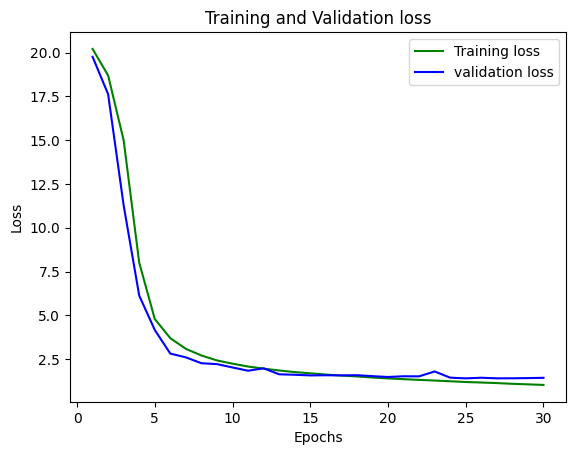

In [22]:
loss_train = np.array(history.history['loss'])
loss_val = np.array(history.history['val_loss'])
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for i in range(valid_size):
        output_text.append(num_to_char(K.get_value(results[i])))
    return output_text


In [27]:
import tensorflow as tf

def decode_batch_predictions(predictions):
    decoded_predictions = []
    for pred in predictions:
        if tf.is_tensor(pred):
            pred_value = pred.numpy()
        else:
            pred_value = pred
        decoded_predictions.append(pred_value)
    return decoded_predictions

model_valid_prediction = model.predict(valid_x)
decoded_valid_prediction = decode_batch_predictions(model_valid_prediction)


313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step


In [29]:
import numpy as np

valid_true_labels = validation_written_df.loc[0:valid_size, 'IDENTITY']
correct = 0

for i in range(valid_size):
    pr = decoded_valid_prediction[i]
    tr = valid_true_labels.iloc[i]

    if np.array_equal(pr, tr):
        correct += 1

print('Correct words in validation predicted: %.2f%%' % (correct * 100 / valid_size))


Correct words in validation predicted: 0.00%


In [31]:
test_written_df = pd.read_csv('C:/Users/brysa/Downloads/ml_project/ai images/written_name_test_v2.csv')
test_size = 10000
test_written_df = cleanDataSet(test_written_df);

# To make sure our indices are one behind the other
test_written_df.reset_index(inplace = True, drop=True)

test_x = []
for i in range(valid_size):
    img_dir = 'C:/Users/brysa/Downloads/ml_project/ai images/test_v2/test/'+test_written_df.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    test_x.append(image)

test_x = np.array(test_x).reshape(-1, 256, 32, 1)
test_y = np.ones([test_size, str_len]) * -1

for i in range(test_size):
    label_num = []
    for ch in test_written_df['IDENTITY'][i]:
        label_num.append(alphabet_characters.index(ch))
    arr = np.array(label_num)
    test_y[i, 0:len(test_written_df.loc[i, 'IDENTITY'])] = arr;

In [33]:
import numpy as np

model_test_prediction = model.predict(test_x)
decoded_test_prediction = decode_batch_predictions(model_test_prediction)

test_labels = test_written_df.loc[0:test_size, 'IDENTITY']
correct = 0

for i in range(test_size):
    pr = decoded_test_prediction[i]
    tr = test_labels.iloc[i]

    if np.array_equal(pr, tr):
        correct += 1

print('Correct words in test predicted: %.2f%%' % (correct * 100 / test_size))


313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step
Correct words in test predicted: 0.00%
